In [21]:
from __future__ import print_function, division

import matplotlib as mpl

import os
import pickle

import numpy as np
import pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import *

In [8]:
if not in_notebook():
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--lside', required=False, help='image size', type=int, default=64)
    parser.add_argument('--epochs', required=False, help='epochs', type=int, default=50000)
    parser.add_argument('--batch_size', required=False, help='batch size', type=int, default=32)
    parser.add_argument('--nld', required=False, help='number d layers', type=int, default=0)
    parser.add_argument('--nlg', required=False, help='number g layers', type=int, default=4)
    parser.add_argument('--ch_scale', required=False, help='channel scale', type=float, default=1.5)
    parser.add_argument('--alpha', required=False, help='alpha', type=float, default=0.01)
    parser.add_argument('--kernel', required=False, help='kernel size', type=int, default=3)
    parser.add_argument('--amin', required=False, help='a min', type=int, default=10)
    parser.add_argument('--amax', required=False, help='a max', type=int, default=0)
    parser.add_argument('--n_masks', required=False, help='n masks', type=int, default=1)
    parser.add_argument('--sinterval', required=False, help='sinterval', type=int, default=200)
    parser.add_argument('--analyze', action="store_true")
    parser.add_argument('--restart', action="store_true")

    parser.add_argument('--nfl', required=False, help='NFL', type=float, default=0)

    args = parser.parse_args()
    lside = args.lside
    epochs = args.epochs
    batch_size = args.batch_size
    n_layers_dis = args.nld
    n_layers_gen = args.nlg

    if n_layers_dis==0:
        n_layers_dis = n_layers_gen-1

    ch_scale = args.ch_scale
    alpha = args.alpha
    kernel_size = args.kernel
    amin = args.amin
    amax = args.amax

    if amax==0:
        amax = amin+20

    n_masks = args.n_masks
    analyze = args.analyze
    sample_interval = args.sinterval
    try_restore = not args.restart

    nfl = args.nfl
    
else:
    lside = 64
    epochs = 10
    batch_size = 32
    n_layers_dis = 0
    n_layers_gen = 3

    if n_layers_dis==0:
        n_layers_dis = n_layers_gen-1

    ch_scale = 1.5
    alpha = 0.1
    kernel_size = 3
    amin = 290
    amax = 0

    if amax==0:
        amax = amin+20

    n_masks = 1
    analyze = True
    sample_interval = 200
    try_restore = True

    nfl = 10
    
path = '../../scratch/gan/'

In [11]:
prefix = 'models_{}_{}_{:2.2f}/l{}_g{}_d{}_ch{}_k{}'.format(amin,amax,nfl,lside,n_layers_gen,n_layers_dis,ch_scale,kernel_size)

ch_mkdir('models_{}_{}_{:2.2f}'.format(amin,amax,nfl))

ch_mkdir(path+'shapes')

shfname = path+'shapes/shapes{:d}_{:d}.pkl'.format(amin,amax)
if os.path.exists(shfname):
    with open(shfname, 'rb') as handle:
        shapes = pickle.load(handle)
else:
    shapes = get_shapes(mask_file=path+'mask.npy',amin=amin,amax=amax)
    with open(shfname, 'wb') as handle:
        pickle.dump(shapes, handle, protocol=pickle.HIGHEST_PROTOCOL)

n_shapes = len(shapes)

cmbs = []
for i in range(10):
    dd = np.load(path+'patches/T'+str(i)+'.npy')
    if nfl!=0:
        dd = dd+nfl*dd**2
    cmbs.append(dd)
cmbs = np.concatenate(cmbs)

cmbs_test = np.load(path+'patches/T10.npy')

print(cmbs.shape)
print(cmbs_test.shape)

prefix = str(alpha)+'/'+prefix+'/'

(120, 2048, 2048)
(12, 2048, 2048)


In [13]:
context_encoder = ContextEncoder(cmbs = cmbs,
                                 cmbs_test = cmbs_test,
                                 shapes = shapes,
                                 ll = lside,
                                 prefix = prefix,
                                 n_masks = n_masks,
                                 n_layers_dis = n_layers_dis,
                                 n_layers_gen = n_layers_gen,
                                 nremax = 20,
                                 ch_scale = ch_scale,
                                 kernel_size = kernel_size,
                                 learning_rate = 0.001,
                                 decay_rate = 0.9995,
                                 alpha = alpha,
                                 try_restore = try_restore)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 64)      

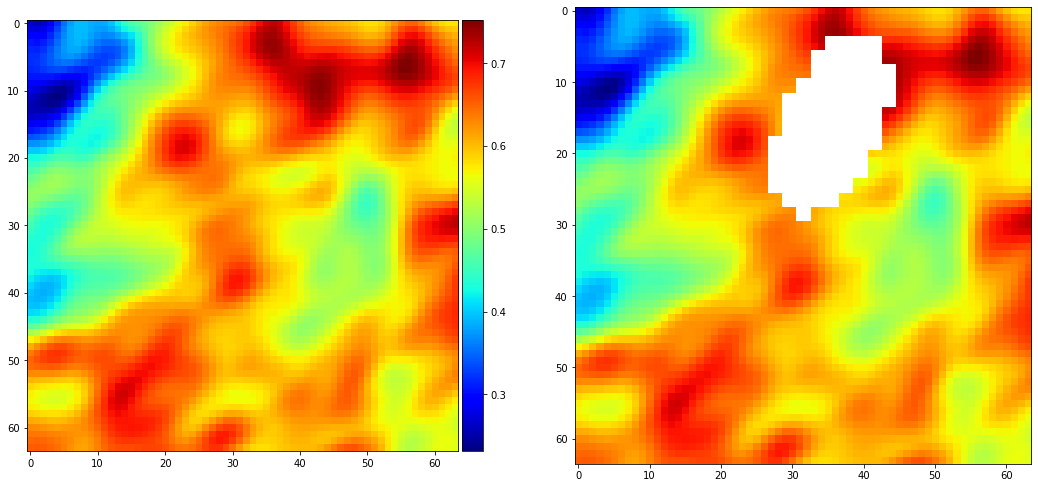

In [62]:
imask, cmb = context_encoder.data_provider_test(batch_size)
masked_cmb = (1-imask)*cmb
missing_parts = imask*cmb

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18,10))

im = ax1.imshow(cmb[0,:,:,0],cmap='jet')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

xx = masked_cmb[0,:,:,0]
xx[xx==0] = np.nan
ax2.imshow(xx,cmap='jet')

In [26]:
learning_rate = None
#learning_rate = 1e-6
context_encoder.decay_rate = 0.99985

context_encoder.train(epochs = epochs,
                      batch_size = batch_size,
                      sample_interval = sample_interval,
                      learning_rate = learning_rate)

0 [D loss: 2.525289, acc: 10.94%] [mse: 0.356847, G loss: 0.324761]
Number of generator/discriminator train 1/7


In [29]:
prefix = '{}/res/mn{}_mx{}_{:2.2f}_l{}_g{}_d{}_ch{}_k{}'.format(alpha,
                                                                amin,
                                                                amax,
                                                                nfl,
                                                                lside,
                                                                n_layers_gen,
                                                                n_layers_dis,
                                                                ch_scale,
                                                                kernel_size)

ch_mkdir('{}/res'.format(alpha))

if analyze:
    for i in range(10,11):
        print('TEST '+str(i))
        cl_path = 'cls/cl_{}.npy'.format(i)
        clw_path = 'cls/clwh_{}_{}_{:2.2f}_{}.npy'.format(amin,amax,nfl,i)
        file_path = path+'patches/T{}.npy'.format(i)
        postfix = '_{}'.format(i)
        
#        if os.path.exists(prefix+'power'+postfix+'.jpg'):
#            continue

        context_encoder.gan_analyze(cl_path = cl_path,
                                    clw_path = clw_path,
                                    file_path = file_path,
                                    prefix = prefix,
                                    postfix = postfix)

TEST 10
807.623346750422


In [30]:
mamin = amin
mamax = amax
tamin = 1
tamax = 1000

In [33]:
num = 10
prefix2 = '{}/res/n{}_tn{}_tx{}_mn{}_mx{}_{:2.2f}_l{}_g{}_d{}_ch{}_k{}_'.format(alpha,
                                                                                num,
                                                                                tamin,
                                                                                tamax,
                                                                                mamin,
                                                                                mamax,
                                                                                nfl,
                                                                                lside,
                                                                                n_layers_gen,
                                                                                n_layers_dis,
                                                                                ch_scale,
                                                                                kernel_size)

cmbs_test = np.load(path+'patches/T'+str(num)+'.npy')

if nfl!=0:
    cmbs_test = cmbs_test+nfl*cmbs_test**2

context_encoder = ContextEncoder(cmbs = cmbs_test,
                                 cmbs_test = cmbs_test,
                                 shapes = shapes,
                                 ll = lside,
                                 prefix = prefix,
                                 n_masks = 1,
                                 n_layers_dis = n_layers_dis,
                                 n_layers_gen = n_layers_gen,
                                 nremax = 20,
                                 ch_scale = ch_scale,
                                 kernel_size = kernel_size,
                                 learning_rate = 0.001,
                                 decay_rate = 0.9995,
                                 try_restore = 0)

context_encoder.load_generator()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 16, 16, 64)      

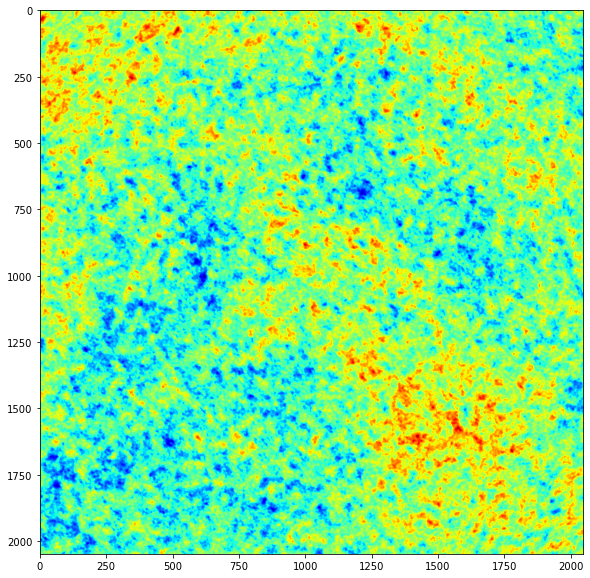

In [35]:
cmbs = cmbs_test
cmbs = cmbs-cmbs.min()
cmbs = cmbs/cmbs.max()

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(cmbs[5],cmap='jet')
# plt.savefig(prefix2+'cmb.jpg',dpi=150)

In [43]:
lp = 2048//64
mask_pp = np.ones((12*lp*lp, 64, 64))
for i in range(0,12*lp*lp):
    imask = mask_maker(shapes = shapes,
                       output_shape = (64,64),
                       n_masks = 1)
    mask_pp[i] = (1-imask)

masks = np.zeros((12, 2048, 2048))
for k in range(12):
    masks[k] = deblock(mask_pp[k*lp*lp:(k+1)*lp*lp,:,:])

mask_pp = []
for i in range(12):
     mask_pp.append(blocker(masks[i], 256, 256))

mask_pp = np.concatenate(mask_pp)

cl_path = 'cls/cl_{}.npy'.format(i)
if not os.path.exists(cl_path):
    fullsky = patch2sky(cmbs)
    fullsky = hp.pixelfunc.reorder(fullsky, inp=None, out=None, r2n=None, n2r=1)
    cl = hp.anafast(fullsky)
    np.save(cl_path[:-4],cl)
else:
    cl = np.load(cl_path)

clw_path = 'cls/clwh_{}_{}_{:2.2f}_{}.npy'.format(mamin,mamax,nfl,i)
if not os.path.exists(clw_path):
    fullsky = cmbs*masks
    fullsky = patch2sky(fullsky)
    fullsky[fullsky==0] = cmbs.mean()
    fullsky = hp.pixelfunc.reorder(fullsky, inp=None, out=None, r2n=None, n2r=1)
    clw = hp.anafast(fullsky)
    np.save(clw_path[:-4],clw)
else:
    clw = np.load(clw_path)

fsg = hp.sphtfunc.synfast(cls=cl, nside=2048)
fsg = hp.pixelfunc.reorder(fsg, inp=None, out=None, r2n=1, n2r=None)

fsg = sky2patch(fsg)
fsg = fsg-fsg.min()
fsg = fsg/fsg.max()

fsg = cmbs*masks+fsg*(1-masks)

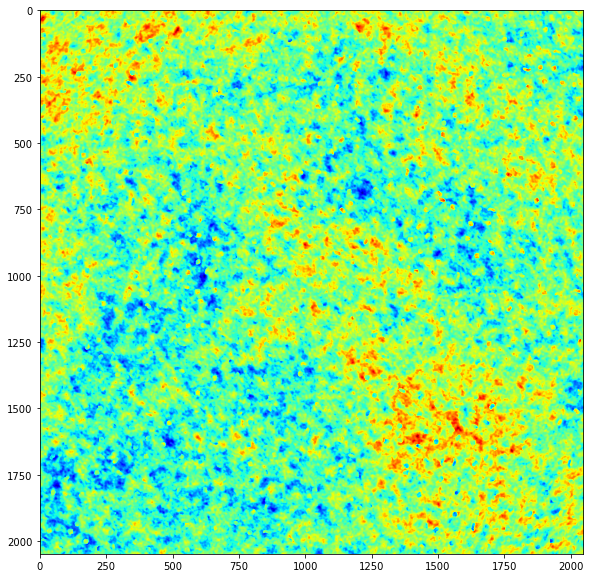

In [45]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(fsg[5],cmap='jet')

In [46]:
# fsg = patch2sky(fsg)
# hp.mollview(fsg,cmap='jet',title='Inpainted',nest=1)
# plt.subplots_adjust(left=0.01,bottom=0.05,right=0.99,top=0.99,wspace=0.01,hspace=0.01)
# # plt.savefig('maps.jpg',dpi=150)

In [48]:
ll = lside
l = 2048//ll

ell = np.arange(len(cl))
dl = ell * (ell + 1) * cl
dlw = ell * (ell + 1) * clw

cmbs_pp = []
for i in range(12):
     cmbs_pp.append(blocker(cmbs[i], ll, ll))

cmbs_pp = np.concatenate(cmbs_pp)

mask_pp = []
for i in range(12):
     mask_pp.append(blocker(masks[i], ll, ll))

mask_pp = np.concatenate(mask_pp)

imasks = 1-mask_pp
masked_cmb = cmbs_pp*mask_pp

imasks = np.array(imasks)[:,:,:,None]
masked_cmb = np.array(masked_cmb)[:,:,:,None]

gen_whole = context_encoder.generator.predict([masked_cmb,imasks])

In [49]:
cmbs3 = np.zeros((12, 2048, 2048))

res1 = []
res2 = []
res3 = []

thresholds = [0.25,0.5,0.75]
for k in range(12):
    cmbs3[k] = deblock(gen_whole[k*l*l:(k+1)*l*l,:,:,0])

    bins,hist,nu,n1,ksis = eval_ksi(cmbs[k],
                                    thresholds = thresholds,
                                    dmin=0,
                                    dmax=1,
                                    nu_num=100,
                                    peak=True,
                                    rmax=300,
                                    crand=5)
    res1.append([bins,hist,nu,n1,ksis])

    bins,hist,nu,n1,ksis = eval_ksi(fsg[k],
                                    thresholds = thresholds,
                                    dmin=0,
                                    dmax=1,
                                    nu_num=100,
                                    peak=True,
                                    rmax=300,
                                    crand=5)
    res2.append([bins,hist,nu,n1,ksis])

    bins,hist,nu,n1,ksis = eval_ksi(cmbs3[k],
                                    thresholds = thresholds,
                                    dmin=0,
                                    dmax=1,
                                    nu_num=100,
                                    peak=True,
                                    rmax=300,
                                    crand=5)
    res3.append([bins,hist,nu,n1,ksis])

21175 4173129
24368 4169936
19147 4175157
21087 4173217
24351 4169953
19105 4175199
21076 4173228
24306 4169998
19110 4175194
20904 4173400
24288 4170016
18922 4175382
20806 4173498
24171 4170133
18870 4175434
20873 4173431
24082 4170222
18976 4175328
20748 4173556
24012 4170292
18801 4175503
20760 4173544
24087 4170217
18820 4175484
21113 4173191
24418 4169886
19124 4175180
20915 4173389
24442 4169862
19047 4175257
21103 4173201
24509 4169795
19100 4175204
20995 4173309
24161 4170143
19020 4175284


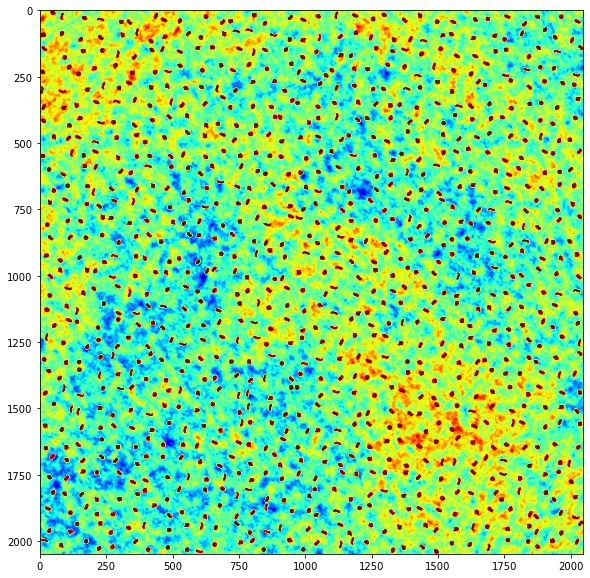

In [50]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(cmbs3[5],cmap='jet')

In [51]:
np.save(prefix2+'res1',res1)
np.save(prefix2+'res2',res2)
np.save(prefix2+'res3',res3)

fullsky3 = patch2sky(cmbs3)
fullsky3 = hp.pixelfunc.reorder(fullsky3, inp=None, out=None, r2n=None, n2r=1)

cl3 = hp.anafast(fullsky3)
dl3 = ell * (ell + 1) * cl3

np.save(prefix2+'clpred',cl3)

/home/vafaeisa/miniconda3/envs/gpu1/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


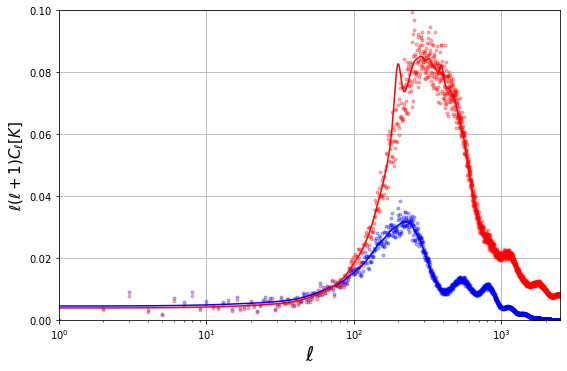

In [56]:
plt.figure(figsize=(8, 5))
plt.plot(ell, dl,color='b',ls='none',marker='.',alpha=0.3)
plt.plot(ell, dl3,color='r',ls='none',marker='.',alpha=0.3)
plt.plot(ell, gaussian_filter(dl,10),color='b')
plt.plot(ell, gaussian_filter(dl3,10),color='r')

plt.xlabel("$\ell$",fontsize=20)
plt.ylabel("$\ell(\ell+1)C_{\ell} [K]$",fontsize=15)
plt.xscale('log')
plt.xlim(1,2500)
plt.ylim(0,0.1)
plt.grid()
plt.subplots_adjust(left=0.12,bottom=0.13,right=0.99,top=0.99,wspace=0.01,hspace=0.01)

In [53]:
xi2pred = np.sum((dl-dl3)**2)
xi2w = np.sum((dl-dlw)**2)
print(xi2pred/xi2w)

791.8425300696814


/home/vafaeisa/miniconda3/envs/gpu1/lib/python3.9/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


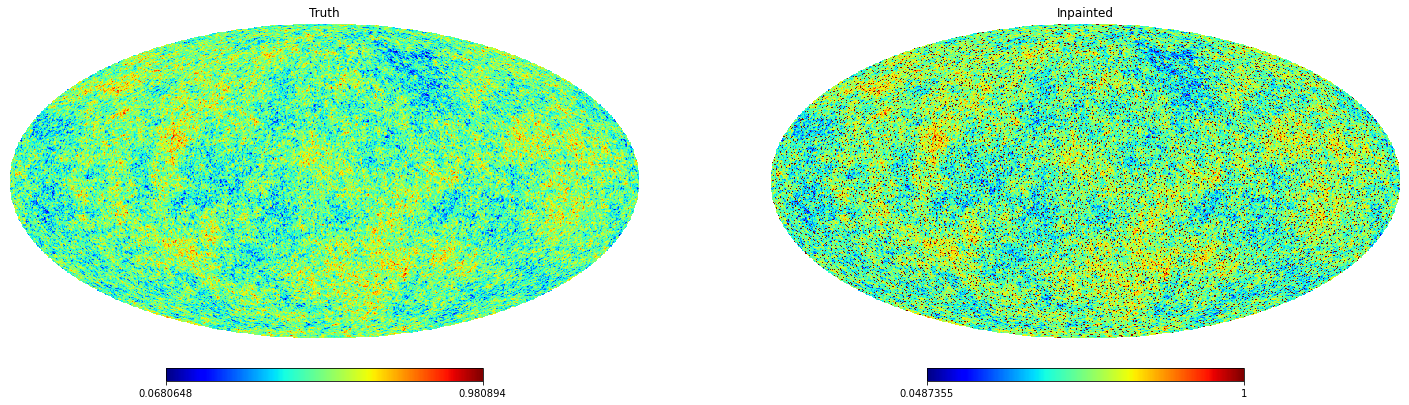

In [57]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(25,10))

plt.sca(ax1)
hp.mollview(fullsky,cmap='jet',title='Truth',hold=1)
plt.sca(ax2)
hp.mollview(fullsky3,cmap='jet',title='Inpainted',hold=1)
plt.subplots_adjust(left=0.01,bottom=0.05,right=0.99,top=0.99,wspace=0.01,hspace=0.01)
# plt.savefig(prefix2+'maps.jpg',dpi=150)
